# Equations of Motion in dRuBbLe
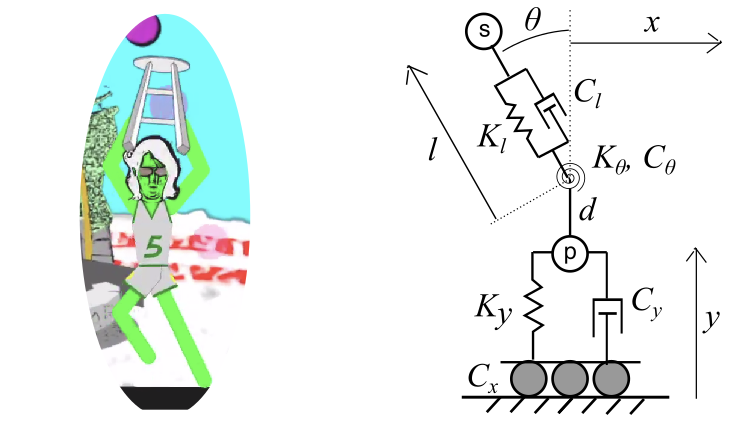

## Setup 
First we import the NumPy and SymPy mechanics modules in Python. NumPy provides an extensive set of numerical analysis funtions, while SymPy is a symbolic coding environment with the mechanics module standardizing various kinematic transformations and and equation of motion generation. The IPython display modules are imported to generate typeset equations suitable for document publication.

In [1]:
import numpy as np
from sympy import *
from sympy.physics.mechanics import *
from IPython.display import display, Latex
init_printing(use_latex='mathjax')

To begin the dynamics model formulation, we first define the generalized coordinates. The player is defined as a point mass located at point $p$, with positions $(x, y)$ defined relative to the origin in the horizontal and vertical directions, respectively. The stool is also defined as a point mass located at point $s$, which is translated and rotated relative to the player with a transformation (to be described later) requiring an arm extension length $l$ and stool tilt angle $θ$. These four variables form the generalized coordinate vector $\boldsymbol{q}$. 

The SymPy Mechanics `dynamicsymbols` function is used to define these as symbolic variables that are time-varying, and therefore candidate degrees-of-freedom (DOFs). Notably, the left hand side of the equation are the variables to be used in the source code, where `th` is used in place of $θ$. When typing code that references the tilt angle, `th` will be used, whereas when the `display` function is called to typeset the equation, the more visually appealing $θ$ is used, as seen below. Also note that the display adds the $(t)$ to each variable, indicating it is time-varying. The chained assignment operators (i.e. `a = b = c`) are used such that in the source code the variables `generalized_coords` and `q` can be used interchangeably.

In [2]:
x, y, l, th = dynamicsymbols('x y l θ')
generalized_coords = q = Matrix([x, y, l, th])
display(Latex('$\mathbf{q} = $'), q)

<IPython.core.display.Latex object>

⎡x(t)⎤
⎢    ⎥
⎢y(t)⎥
⎢    ⎥
⎢l(t)⎥
⎢    ⎥
⎣θ(t)⎦

We will also need the derivatives of these coordinates with respect to time, which are obtained by calling the `dynamicsymbols` function with the second argument `1` indicating the first derivative.

In [3]:
dxdt, dydt, dldt, dthdt = dynamicsymbols('x y l θ', 1)
ddt_generalized_coords = dqdt = Matrix([dxdt, dydt, dldt, dthdt])
d2xdt2, d2ydt2, d2ldt2, d2thdt2 = dynamicsymbols('x y l θ', 2)
d2dt2_generalized_coords = d2qdt2 = Matrix([d2xdt2, d2ydt2, d2ldt2, d2thdt2])
display(Latex('$\dot{\mathbf{q}} = $'), dqdt)
display(Latex('$\ddot{\mathbf{q}} = $'), d2qdt2)

<IPython.core.display.Latex object>

⎡d       ⎤
⎢──(x(t))⎥
⎢dt      ⎥
⎢        ⎥
⎢d       ⎥
⎢──(y(t))⎥
⎢dt      ⎥
⎢        ⎥
⎢d       ⎥
⎢──(l(t))⎥
⎢dt      ⎥
⎢        ⎥
⎢d       ⎥
⎢──(θ(t))⎥
⎣dt      ⎦

<IPython.core.display.Latex object>

⎡  2      ⎤
⎢ d       ⎥
⎢───(x(t))⎥
⎢  2      ⎥
⎢dt       ⎥
⎢         ⎥
⎢  2      ⎥
⎢ d       ⎥
⎢───(y(t))⎥
⎢  2      ⎥
⎢dt       ⎥
⎢         ⎥
⎢  2      ⎥
⎢ d       ⎥
⎢───(l(t))⎥
⎢  2      ⎥
⎢dt       ⎥
⎢         ⎥
⎢  2      ⎥
⎢ d       ⎥
⎢───(θ(t))⎥
⎢  2      ⎥
⎣dt       ⎦

Initial values for the generalized coordinates are represented by a subscript $0$, where $\boldsymbol{q}_0 = (x_0, y_0, l_0, θ_0)^T$. In SymPy, these are defined using a call to the `symbols` function, which declares them as constants. As before, a slight variation is used for the variable representation in the source code versus in typesetting, where for the latter the underscore is used to ensure that these are typeset as a subscript.

In [4]:
x0, y0, l0, th0 = symbols('x_0 y_0 l_0 θ_0')
q0 = Matrix([x0, y0, l0, th0])
display(Latex('$\mathbf{q}_0 = $'), q0)

<IPython.core.display.Latex object>

⎡x₀⎤
⎢  ⎥
⎢y₀⎥
⎢  ⎥
⎢l₀⎥
⎢  ⎥
⎣θ₀⎦

To facilitate equation of motion generation using Kane's method, we will also define a set of generalized speeds. In this case, we will use substition variables $u = \frac{\partial x}{\partial t}$, $v = \frac{\partial y}{\partial t}$, $w = \frac{\partial l}{\partial t}$, and $ω = \frac{\partial θ}{\partial t}$.

In [5]:
u, v, w, omeg = dynamicsymbols('u v w ω')
generalized_speeds = s = Matrix([u, v, w, omeg])
display(Latex('$\mathbf{s} = $'), generalized_speeds)

<IPython.core.display.Latex object>

⎡u(t)⎤
⎢    ⎥
⎢v(t)⎥
⎢    ⎥
⎢w(t)⎥
⎢    ⎥
⎣ω(t)⎦

A kinematic equation will be used in Kane's method to define the equality $\mathbf{s} = \dot{\mathbf{q}}$, equivalently $\mathbf{s} - \dot{\mathbf{q}} = \mathbf{0}$. The latter convention is commonly used by the SymPy solvers, where a matrix representing a system of equations will be assumed to be in equilibrium, or in other words equal to a matrix of zeros with the same dimension.

In [6]:
kinematic_equation = s - dqdt
display(kinematic_equation)

⎡       d       ⎤
⎢u(t) - ──(x(t))⎥
⎢       dt      ⎥
⎢               ⎥
⎢       d       ⎥
⎢v(t) - ──(y(t))⎥
⎢       dt      ⎥
⎢               ⎥
⎢       d       ⎥
⎢w(t) - ──(l(t))⎥
⎢       dt      ⎥
⎢               ⎥
⎢       d       ⎥
⎢ω(t) - ──(θ(t))⎥
⎣       dt      ⎦

Next we define the constants, including masses $m_p$ and $m_s$ of the player and stool, an offset distance $d$ between the player center of mass and the point about which the stool rotates, the gravitational constant $'g'$ (represented by `grav` in source code). 

In [7]:
mp, ms, d, grav, t = symbols('m_p m_s d g t')

The spring coefficients $K_y$, $K_l$, and $K_θ$ introduce generalized forces into the system proportional to the subscripted coordinate minus its initial value. 

In [8]:
Ky, Kl, Kt = symbols('K_y K_l K_θ')

Likewise, the damping constants $C_x$, $C_y$, $C_l$, and $C_θ$ induce generalized forces proportional to derivatives with respect to time of the generalized coordinates.

In [9]:
Cx, Cy, Cl, Cth = symbols('C_x C_y C_l C_θ')
generalized_damping_forces = Qdamping = Matrix([- Cx * dxdt, - Cy * dydt, - Cl * dldt, - Cth * dthdt])
display(Latex('$\mathbf{Q}_{damping} = $'), generalized_damping_forces)

<IPython.core.display.Latex object>

⎡    d        ⎤
⎢-Cₓ⋅──(x(t)) ⎥
⎢    dt       ⎥
⎢             ⎥
⎢     d       ⎥
⎢-C_y⋅──(y(t))⎥
⎢     dt      ⎥
⎢             ⎥
⎢    d        ⎥
⎢-Cₗ⋅──(l(t)) ⎥
⎢    dt       ⎥
⎢             ⎥
⎢     d       ⎥
⎢-C_θ⋅──(θ(t))⎥
⎣     dt      ⎦

The generalized input forces $Q_x$, $Q_y$, $Q_l$, and $Q_θ$ represent the control variables, from either player inputs or the computer control logic algorithm.

In [10]:
Qx, Qy, Ql, Qth = symbols('Q_x Q_y Q_l Q_θ')
generalized_input_forces = Qinput = Matrix([Qx, Qy, Ql, Qth])
display(Latex('$\mathbf{Q}_{input} = $'), Qinput)

<IPython.core.display.Latex object>

⎡Qₓ ⎤
⎢   ⎥
⎢Q_y⎥
⎢   ⎥
⎢Qₗ ⎥
⎢   ⎥
⎣Q_θ⎦

## Kinematics
The inertial reference frame is designated as `R`. The default convention in SymPy Mechanics is to represent the reference frame `R` using the unit vectors $\mathbf{\hat{r}}_x$, $\mathbf{\hat{r}}_y$, and $\mathbf{\hat{r}}_z$, however, these default symbols are replaced with unit vectors $\mathbf{\hat{i}}$, $\mathbf{\hat{j}}$, and $\mathbf{\hat{k}}$ for typesetting purposes, where $\mathbf{\hat{i}}$ is horizontal to the right side of the screen, $\mathbf{\hat{j}}$ is vertical and upward, and $\mathbf{\hat{k}}$ is out of the page. It is understood these are spatially fixed such that  $\partial\mathbf{\hat{i}} / \partial t = \partial\mathbf{\hat{j}} / \partial t = \partial\mathbf{\hat{k}} / \partial t = 0$. The stool frame is designated as `E`, with the default unit vectors provided by SymPy Mechanics of $\mathbf{\hat{e}}_x$, $\mathbf{\hat{e}}_y$, and $\mathbf{\hat{e}}_z$, which are oriented relative to the reference frame `R` by a rotation of $\theta$ about the $\mathbf{\hat{k}}$ axis, where $\mathbf{\hat{k}}$ is accessed in the source code as `R.z`. The direction cosine matrix (DCM) that transforms from the `R` to the `E` frame is given by $\mathbf{R}_e$.

In [11]:
R = ReferenceFrame('R')
R.pretty_vecs = ['i', 'j', 'k']
R.latex_vecs = ['\\mathbf{\\hat{i}}', '\\mathbf{\\hat{j}}', '\\mathbf{\\hat{k}}']
E = ReferenceFrame('E')
E.orient(R, 'Axis', [th, R.z])
Re = E.dcm(R)
display(Latex('$\mathbf{R}_e =$'), Re)

<IPython.core.display.Latex object>

⎡cos(θ(t))   sin(θ(t))  0⎤
⎢                        ⎥
⎢-sin(θ(t))  cos(θ(t))  0⎥
⎢                        ⎥
⎣    0           0      1⎦

The origin is defined as a `Point` designated `O`, and its velocity is set to zero using the `.set_vel()` method. The ensuing points of interest will be defined relative to the origin.

In [12]:
origin = Point('O')
origin.set_vel(R, 0)

The player's center of mass is located at the point `p`, which has the position vector $\mathbf{r}_p$ given by the generalized coordinates $x$ and $y$, measured relative to the origin in the `R` frame. The `.set_pos()` method is used to define this position, with the source code `R.x` and `R.y` to access the unit vectors $\mathbf{\hat{i}}$ and $\mathbf{\hat{j}}$, respectively.

In [13]:
player = Point('p')
player.set_pos(origin, x * R.x + y * R.y)
rp = player.pos_from(origin)
display(Latex('$\mathbf{r}_p = $'), rp)

<IPython.core.display.Latex object>

x(t) i + y(t) j

The stool center of mass is located at the point `s`, which has the position vector $\mathbf{r}_s$, which is offset vertically from `p` by a constant distance $d$ in the $\partial\mathbf{\hat{j}}$ direction, and by $l(t)$ in the $\mathbf{\hat{e}}_y$ direction (accessed as `E.y` in the source code).

In [14]:
stool = Point('s')
stool.set_pos(player, d * R.y + l * E.y)
rs = stool.pos_from(origin)
display(Latex('$\mathbf{r}_s = $'), rs, Latex('$ = $'), rs.express(R))

<IPython.core.display.Latex object>

x(t) i + (d + y(t)) j + l(t) e_y

<IPython.core.display.Latex object>

(-l(t)⋅sin(θ(t)) + x(t)) i + (d + l(t)⋅cos(θ(t)) + y(t)) j

The velocity of the point `p`, given by $\mathbf{v}_p$, is calculated by taking its time derivative evaluated in the frame `R`.

In [15]:
vp = player.pos_from(origin).dt(R) 
display(Latex('$\mathbf{v}_p =$'), vp)

<IPython.core.display.Latex object>

d            d
──(x(t)) i + ──(y(t)) j
dt           dt

Similarly, the velocity of the point `s`, given by $\mathbf{v}_s$ is calculated in the same way. By default, the velocity of `s` relative to `p` is given in the rotated stool frame, with a tangential term $l\dot{\theta}\hat{\mathbf{e}}_x$ and radial term $\dot{l}\hat{\mathbf{e}}_y$. The `.express()` method is used to give the equivalent velocity in the inertial $\hat{\mathbf{i}}$ and $\hat{\mathbf{j}}$ coordinates.

In [16]:
vs = stool.pos_from(origin).dt(R) 
display(Latex('$\mathbf{v}_s =$'), vs, Latex('$ = $'), vs.express(R))

<IPython.core.display.Latex object>

d            d                  d              d
──(x(t)) i + ──(y(t)) j + -l(t)⋅──(θ(t)) e_x + ──(l(t)) e_y
dt           dt                 dt             dt

<IPython.core.display.Latex object>

⎛                 d                    d          d       ⎞     ⎛
⎜- l(t)⋅cos(θ(t))⋅──(θ(t)) - sin(θ(t))⋅──(l(t)) + ──(x(t))⎟ i + ⎜- l(t)⋅sin(θ(
⎝                 dt                   dt         dt      ⎠     ⎝

    d                    d          d       ⎞
t))⋅──(θ(t)) + cos(θ(t))⋅──(l(t)) + ──(y(t))⎟ j
    dt                   dt         dt      ⎠

## Lagrange's Method
The kinetic energy, $T = \frac{1}{2} m_p \mathbf{v}_p \cdot \mathbf{v}_p + \frac{1}{2} m_s \mathbf{v}_s \cdot \mathbf{v}_s$, is calculated where $m_p$ and $m_s$ are the point masses assigned to the player and stool, and $(\,\cdot\,)$ represents the dot product.

In [17]:
T = simplify(0.5 * mp * dot(vp, vp) + 0.5 * ms * dot(vs, vs))
display(Latex('$T = $'), T)

<IPython.core.display.Latex object>

                 2                    2                          2            
       ⎛d       ⎞           ⎛d       ⎞            2    ⎛d       ⎞             
0.5⋅mₚ⋅⎜──(x(t))⎟  + 0.5⋅mₚ⋅⎜──(y(t))⎟  + 0.5⋅mₛ⋅l (t)⋅⎜──(θ(t))⎟  - 1.0⋅mₛ⋅l(
       ⎝dt      ⎠           ⎝dt      ⎠                 ⎝dt      ⎠             

                                                                              
             d        d                                d        d             
t)⋅sin(θ(t))⋅──(y(t))⋅──(θ(t)) - 1.0⋅mₛ⋅l(t)⋅cos(θ(t))⋅──(x(t))⋅──(θ(t)) - 1.0
             dt       dt                               dt       dt            

                                                                              
              d        d                           d        d                 
⋅mₛ⋅sin(θ(t))⋅──(l(t))⋅──(x(t)) + 1.0⋅mₛ⋅cos(θ(t))⋅──(l(t))⋅──(y(t)) + 0.5⋅mₛ⋅
              dt       dt                          dt       dt                

          2                    2                 

The potential energy $V$ is the sum of the gravitational potential $(m_p \mathbf{r}_p + m_s \mathbf{r_s}) \cdot g \hat{\mathbf{j}}$ plus spring potential $K_y (y - y_0)^2$, $K_l (l - l_0)^2$, and $K_\theta \theta^2$. 

In [18]:
V = dot(mp * rp + ms * rs, grav * R.y) + 0.5 * ( Ky * (y - y0)**2 + Kl * (l - l0)**2 + Kt * th**2 )
V = simplify(V)
display(Latex('$V = $'), V)

<IPython.core.display.Latex object>

                  2                      2            2                       
0.5⋅Kₗ⋅(l₀ - l(t))  + 0.5⋅K_y⋅(y₀ - y(t))  + 0.5⋅K_θ⋅θ (t) + g⋅mₛ⋅l(t)⋅cos(θ(t

                                
)) + g⋅(mₚ⋅y(t) + mₛ⋅(d + y(t)))

The Lagrangian $L = T - V$

In [19]:
L = T - V
display(Latex('$L = T - V = $'), L)

<IPython.core.display.Latex object>

                                                                              
                    2                      2            2                     
- 0.5⋅Kₗ⋅(l₀ - l(t))  - 0.5⋅K_y⋅(y₀ - y(t))  - 0.5⋅K_θ⋅θ (t) - g⋅mₛ⋅l(t)⋅cos(θ
                                                                              

                                                      2                    2  
                                            ⎛d       ⎞           ⎛d       ⎞   
(t)) - g⋅(mₚ⋅y(t) + mₛ⋅(d + y(t))) + 0.5⋅mₚ⋅⎜──(x(t))⎟  + 0.5⋅mₚ⋅⎜──(y(t))⎟  +
                                            ⎝dt      ⎠           ⎝dt      ⎠   

                        2                                                     
         2    ⎛d       ⎞                          d        d                  
 0.5⋅mₛ⋅l (t)⋅⎜──(θ(t))⎟  - 1.0⋅mₛ⋅l(t)⋅sin(θ(t))⋅──(y(t))⋅──(θ(t)) - 1.0⋅mₛ⋅l
              ⎝dt      ⎠                          dt       dt                 

                                                 

Equations of motion are calculated using Lagrange's method, $\frac{d}{dt} \left( \frac{\partial L}{\partial\dot{\mathbf{q}}}\right) - \frac{\partial L}{\partial \mathbf{q}} = \mathbf{Q}_{damping} + \mathbf{Q}_{input}$, or equivalently $\frac{d}{dt} \left( \frac{\partial L}{\partial\dot{\mathbf{q}}}\right) - \frac{\partial L}{\partial \mathbf{q}} - \mathbf{Q}_{damping} - \mathbf{Q}_{input} = \mathbf{0}$.

In [20]:
# Initialize the eom matrix
eom = Matrix([None, None, None, None])

for k in range(4):
    # Apply Lagrange's method
    tmp = diff(diff(L, dqdt[k]), t) - diff(L, q[k]) - Qdamping[k] - Qinput[k]
    
    # Simplify and insert into eom matrix
    eom[k] = simplify(tmp)

    # Display result
    display('EOM for ' + str(q[k]) + ' is : ', eom[k], '')

'EOM for x(t) is : '

                            2                                         2       
   d                       d                                ⎛d       ⎞        
Cₓ⋅──(x(t)) - Qₓ + 1.0⋅mₚ⋅───(x(t)) + 1.0⋅mₛ⋅l(t)⋅sin(θ(t))⋅⎜──(θ(t))⎟  - 1.0⋅
   dt                       2                               ⎝dt      ⎠        
                          dt                                                  

                    2                            2                            
                   d                            d                           d 
mₛ⋅l(t)⋅cos(θ(t))⋅───(θ(t)) - 1.0⋅mₛ⋅sin(θ(t))⋅───(l(t)) - 2.0⋅mₛ⋅cos(θ(t))⋅──
                    2                            2                          dt
                  dt                           dt                             

                           2      
       d                  d       
(l(t))⋅──(θ(t)) + 1.0⋅mₛ⋅───(x(t))
       dt                  2      
                         dt       

''

'EOM for y(t) is : '

                                                                  2           
    d                                                            d            
C_y⋅──(y(t)) - 1.0⋅K_y⋅(y₀ - y(t)) - Q_y + g⋅(mₚ + mₛ) + 1.0⋅mₚ⋅───(y(t)) - 1.
    dt                                                            2           
                                                                dt            

                      2                                         2             
                     d                                ⎛d       ⎞              
0⋅mₛ⋅l(t)⋅sin(θ(t))⋅───(θ(t)) - 1.0⋅mₛ⋅l(t)⋅cos(θ(t))⋅⎜──(θ(t))⎟  - 2.0⋅mₛ⋅sin
                      2                               ⎝dt      ⎠              
                    dt                                                        

                                              2                  2      
       d        d                            d                  d       
(θ(t))⋅──(l(t))⋅──(θ(t)) + 1.0⋅mₛ⋅cos(θ(t))⋅───(l(t)) + 1.0⋅mₛ

''

'EOM for l(t) is : '

                                                                              
       d                                                                      
1.0⋅Cₗ⋅──(l(t)) - 1.0⋅Kₗ⋅l₀ + 1.0⋅Kₗ⋅l(t) - 1.0⋅Qₗ + 1.0⋅g⋅mₛ⋅cos(θ(t)) - 1.0⋅
       dt                                                                     
                                                                              

                  2                      2                            2       
        ⎛d       ⎞                      d                            d        
mₛ⋅l(t)⋅⎜──(θ(t))⎟  - 1.0⋅mₛ⋅sin(θ(t))⋅───(x(t)) + 1.0⋅mₛ⋅cos(θ(t))⋅───(y(t)) 
        ⎝dt      ⎠                       2                            2       
                                       dt                           dt        

           2      
          d       
+ 1.0⋅mₛ⋅───(l(t))
           2      
         dt       

''

'EOM for θ(t) is : '

                                                                         2    
    d                                                             2     d     
C_θ⋅──(θ(t)) + 1.0⋅K_θ⋅θ(t) - Q_θ - g⋅mₛ⋅l(t)⋅sin(θ(t)) + 1.0⋅mₛ⋅l (t)⋅───(θ(t
    dt                                                                   2    
                                                                       dt     

                             2                                 2              
                            d                                 d               
)) - 1.0⋅mₛ⋅l(t)⋅sin(θ(t))⋅───(y(t)) - 1.0⋅mₛ⋅l(t)⋅cos(θ(t))⋅───(x(t)) + 2.0⋅m
                             2                                 2              
                           dt                                dt               

                        
       d        d       
ₛ⋅l(t)⋅──(l(t))⋅──(θ(t))
       dt       dt      
                        

''

Next solve the equations of motion for the accelerations, $\partial{\boldsymbol{q}} / \partial t$, using the SymPy `solve` function. This returns a dictionary where the keys are the symbolic variables for $\partial \mathbf{q} / \partial t$. The loop simplifies the solution equations, and places them into a list that is given in the original order of `eom`. 

In [21]:
# Solve for the accelerations
eom_solved = solve(eom, d2qdt2)

# Initialize the eoms matrix
eoms = Matrix([None, None, None, None])

for k in range(4):
    # Insert the equation from the eom_solved dictionary indexed using d2qdt2
    eoms[k] = simplify(eom_solved[d2qdt2[k]])
    
    # Display the equation
    print(' ')
    display(d2qdt2[k], ' = ', eoms[k])  

  2      
 d       
───(x(t))
  2      
dt       

' = '

                    d                  d                        d             
- Cₗ⋅l(t)⋅sin(θ(t))⋅──(l(t)) - Cₓ⋅l(t)⋅──(x(t)) - C_θ⋅cos(θ(t))⋅──(θ(t)) + Kₗ⋅
                    dt                 dt                       dt            
──────────────────────────────────────────────────────────────────────────────
                                                                              

                        2                                                     
l₀⋅l(t)⋅sin(θ(t)) - Kₗ⋅l (t)⋅sin(θ(t)) - K_θ⋅θ(t)⋅cos(θ(t)) + Qₗ⋅l(t)⋅sin(θ(t)
                                                                              
──────────────────────────────────────────────────────────────────────────────
          mₚ⋅l(t)                                                             

                           
) + Qₓ⋅l(t) + Q_θ⋅cos(θ(t))
                           
───────────────────────────
                           

  2      
 d       
───(y(t))
  2      
dt       

' = '

             ⎛      d                        ⎞             ⎛             d    
-g⋅mₚ⋅l(t) + ⎜- C_θ⋅──(θ(t)) - K_θ⋅θ(t) + Q_θ⎟⋅sin(θ(t)) + ⎜Cₗ⋅cos(θ(t))⋅──(l(
             ⎝      dt                       ⎠             ⎝             dt   
──────────────────────────────────────────────────────────────────────────────
                                                                              

          d                                                                   
t)) - C_y⋅──(y(t)) - Kₗ⋅l₀⋅cos(θ(t)) + Kₗ⋅l(t)⋅cos(θ(t)) + K_y⋅y₀ - K_y⋅y(t) -
          dt                                                                  
──────────────────────────────────────────────────────────────────────────────
         mₚ⋅l(t)                                                              

                   ⎞     
 Qₗ⋅cos(θ(t)) + Q_y⎟⋅l(t)
                   ⎠     
─────────────────────────
                         

  2      
 d       
───(l(t))
  2      
dt       

' = '

                     2                                                        
           ⎛d       ⎞       ⎛     d                              ⎞      ⎛     
mₚ⋅mₛ⋅l(t)⋅⎜──(θ(t))⎟  + mₚ⋅⎜- Cₗ⋅──(l(t)) + Kₗ⋅l₀ - Kₗ⋅l(t) + Qₗ⎟ + mₛ⋅⎜- Cₗ⋅
           ⎝dt      ⎠       ⎝     dt                             ⎠      ⎝     
──────────────────────────────────────────────────────────────────────────────
                                                                              

                                                                              
d                       d                        d                            
──(l(t)) - Cₓ⋅sin(θ(t))⋅──(x(t)) + C_y⋅cos(θ(t))⋅──(y(t)) + Kₗ⋅l₀ - Kₗ⋅l(t) - 
dt                      dt                       dt                           
──────────────────────────────────────────────────────────────────────────────
                                  mₚ⋅mₛ                                       

                                                  

  2      
 d       
───(θ(t))
  2      
dt       

' = '

                       d                                d                 d   
- Cₓ⋅mₛ⋅l(t)⋅cos(θ(t))⋅──(x(t)) - C_y⋅mₛ⋅l(t)⋅sin(θ(t))⋅──(y(t)) - C_θ⋅mₚ⋅──(θ
                       dt                               dt                dt  
──────────────────────────────────────────────────────────────────────────────
                                                                              
                                                                              

              d                                                               
(t)) - C_θ⋅mₛ⋅──(θ(t)) + K_y⋅mₛ⋅y₀⋅l(t)⋅sin(θ(t)) - K_y⋅mₛ⋅l(t)⋅y(t)⋅sin(θ(t))
              dt                                                              
──────────────────────────────────────────────────────────────────────────────
                                                                 2            
                                                          mₚ⋅mₛ⋅l (t)         

                                                  

## Code Generation
Next we substitute variables into the equation to create printed text that can be inserted into ordinary Python source code. The printed output represents the code to be implemented in a function of the form `du = f(u)`, where `u` is the list of state variables, and `du` are the derivatives of `u` with respect to time. Additionally, this code presumes the existence of a parameter structure `p` containing the constants, and generalized force variables `Qx, Qy, Ql, Qth`.

This is done in two steps, first using the `.subs()` method which replaces symbolic variables in the equation, but returns an object of the symbolic data type. The second step is to change to a string data type, then use the `.replace()` method to swap in new strings that are shorter and/or more compatible with standard Python source code. It is worth noting that this entire operation could be using the second, string replacement method, but the symbolic substition is inclued for demonstration purposes.

The process begins by defining symbolic or string replacements. The symbols in `dq` are shortened form for the dynamic symbols previously created in the `dqdt`. Where the latter would print long strings intended for typeset display (i.e. `Derivative(x(t), t)` which is typeset as $\frac{\partial}{\partial t} x(t)$), the replacement are 2 or 3 ascii characters (i.e. `dx`). 

The list `qstr` are simply the named set of state variables in the list `u`, which are included for readability of the string formatted equations of motion.

The string replacements are defined in `replist`, which is a $N\times 2$ list. In each row, the first entry (`replist[n][0]`) is the "old string", or expected pattern in the original string output, and the second entry (`replist[n][1]`) is the "new string", which replaces it.

In [22]:
# Define shortened symbols to replace using the subs command
dx, dy, dl, dth = symbols('dx dy dl dθ')
dq = Matrix([dx, dy, dl, dth]) 

# Define the variable names that are included in the list 'u'
qstr = 'x', 'y', 'l', 'th', 'dx', 'dy', 'dl', 'dth'

# Define the list of variables to replace in the string
replist = [['sin(θ(t))', 's'], ['cos(θ(t))', 'c'],
           ['x(t)', 'x'], ['y(t)', 'y'], ['l(t)', 'l'], ['θ(t)', 'th'], ['dθ', 'dth'],
           ['x_0', 'p.x0'], ['y_0', 'p.y0'], ['l_0', 'p.l0'],  
           ['m_p', 'p.mp'], ['m_s', 'p.ms'], ['g', 'p.g'],
           ['K_x', 'p.Kx'], ['K_y', 'p.Ky'], ['K_l', 'p.Kl'], ['K_θ', 'p.Kth'],
           ['C_x', 'p.Cx'], ['C_y', 'p.Cy'], ['C_l', 'p.Cl'], ['C_θ', 'p.Cth'], 
           ['Q_x', 'Qx'], ['Q_y', 'Qy'],['Q_l', 'Ql'], ['Q_θ', 'Qth']]

# Initialize the string formatted EOMs
eoms_print = ['du[4] = ', 'du[5] = ', 'du[6] = ', 'du[7] = ']

# Print string that unpacks the state variables
for k in range(4):
    print(qstr[k], '= u[' + str(k) + ']')
    print(' ')
    
# Print the shortened sine and cosine    
print('s = sin(th)')
print(' ')
print('c = cos(th)')
print(' ')    

# Print the velocity assignments
for k in range(4):
    print('du[' + str(k) + '] =', qstr[k+4], '= u[' + str(k+4) + ']')
    print(' ')
    
for k in range(4):
    # Load a copy of the eoms into the tmp_symbolic variable
    tmp_symbolic = eoms[k]
    
    # Replace the velocity terms with shortened variable
    # names (i.e. Derivative(x(t), t) replaced with dx)
    for j in range(4):
        tmp_symbolic = tmp_symbolic.subs(dqdt[j], dq[j])
    
    # Create a temporary string formatted equation
    tmp_string = str(tmp_symbolic)
    
    # Replace old_string with new_string from the replist
    for old_string, new_string in replist:
        tmp_string = tmp_string.replace(old_string, new_string)

    # Replace the print string with tmp, and print result
    eoms_print[k] += tmp_string
    print(eoms_print[k])
    print(' ')

x = u[0]
 
y = u[1]
 
l = u[2]
 
th = u[3]
 
s = sin(th)
 
c = cos(th)
 
du[0] = dx = u[4]
 
du[1] = dy = u[5]
 
du[2] = dl = u[6]
 
du[3] = dth = u[7]
 
du[4] = (-p.Cl*dl*l*s - p.Cx*dx*l - p.Cth*dth*c + p.Kl*p.l0*l*s - p.Kl*l**2*s - p.Kth*th*c + Ql*l*s + Qx*l + Qth*c)/(p.mp*l)
 
du[5] = (-p.g*p.mp*l + (-p.Cth*dth - p.Kth*th + Qth)*s + (p.Cl*dl*c - p.Cy*dy - p.Kl*p.l0*c + p.Kl*l*c + p.Ky*p.y0 - p.Ky*y - Ql*c + Qy)*l)/(p.mp*l)
 
du[6] = (dth**2*p.mp*p.ms*l + p.mp*(-p.Cl*dl + p.Kl*p.l0 - p.Kl*l + Ql) + p.ms*(-p.Cl*dl - p.Cx*dx*s + p.Cy*dy*c + p.Kl*p.l0 - p.Kl*l - p.Ky*p.y0*c + p.Ky*y*c + Ql + Qx*s - Qy*c))/(p.mp*p.ms)
 
du[7] = (-p.Cx*dx*p.ms*l*c - p.Cy*dy*p.ms*l*s - p.Cth*dth*p.mp - p.Cth*dth*p.ms + p.Ky*p.ms*p.y0*l*s - p.Ky*p.ms*l*y*s - p.Kth*p.mp*th - p.Kth*p.ms*th + Qx*p.ms*l*c + Qy*p.ms*l*s + Qth*p.mp + Qth*p.ms - 2.0*dl*dth*p.mp*p.ms*l)/(p.mp*p.ms*l**2)
 


## Mass Matrix
The mass matrix is calculated by taking the derivative of each equation of motion with respect to each acceleration term. The primary terms are found along the diagonal, the first three reflect the player and stool mass for the translational DOFs, and the fourth represents the effective moment of inertia for the stool mass eccentricity from its rotation center. The mass matrix inverse is also calculated.

In [23]:
M = Matrix([[None, None, None, None],
            [None, None, None, None],
            [None, None, None, None],
            [None, None, None, None]])

for j in range(4):
    for k in range(4):
        M[j, k] = diff(eom[j], d2qdt2[k])
        
display(Latex('$\mathbf{M} = $'), M)        
display(Latex('$\mathbf{M}^{-1} = $'), simplify(M.inv()))

<IPython.core.display.Latex object>

⎡   1.0⋅mₚ + 1.0⋅mₛ                0             -1.0⋅mₛ⋅sin(θ(t))  -1.0⋅mₛ⋅l(
⎢                                                                             
⎢          0                1.0⋅mₚ + 1.0⋅mₛ      1.0⋅mₛ⋅cos(θ(t))   -1.0⋅mₛ⋅l(
⎢                                                                             
⎢  -1.0⋅mₛ⋅sin(θ(t))        1.0⋅mₛ⋅cos(θ(t))          1.0⋅mₛ                  
⎢                                                                             
⎢                                                                             
⎣-1.0⋅mₛ⋅l(t)⋅cos(θ(t))  -1.0⋅mₛ⋅l(t)⋅sin(θ(t))          0               1.0⋅m

t)⋅cos(θ(t))⎤
            ⎥
t)⋅sin(θ(t))⎥
            ⎥
0           ⎥
            ⎥
   2        ⎥
ₛ⋅l (t)     ⎦

<IPython.core.display.Latex object>

⎡     1.0                         1.0⋅sin(θ(t))   1.0⋅cos(θ(t))⎤
⎢     ───              0          ─────────────   ─────────────⎥
⎢      mₚ                               mₚ           mₚ⋅l(t)   ⎥
⎢                                                              ⎥
⎢                     1.0        -1.0⋅cos(θ(t))   1.0⋅sin(θ(t))⎥
⎢      0              ───        ───────────────  ─────────────⎥
⎢                      mₚ               mₚ           mₚ⋅l(t)   ⎥
⎢                                                              ⎥
⎢1.0⋅sin(θ(t))  -1.0⋅cos(θ(t))      1.0   1.0                  ⎥
⎢─────────────  ───────────────     ─── + ───           0      ⎥
⎢      mₚ              mₚ            mₛ    mₚ                  ⎥
⎢                                                              ⎥
⎢1.0⋅cos(θ(t))   1.0⋅sin(θ(t))                    1.0⋅(mₚ + mₛ)⎥
⎢─────────────   ─────────────          0         ─────────────⎥
⎢   mₚ⋅l(t)         mₚ⋅l(t)                               2    ⎥
⎣                        